# Training con PyTorch: KA Network (pykan) e MLP sul Boston Housing Dataset

In questo Notebook addestriamo due modelli per stimare il prezzo medio delle abitazioni:

1. **KA Network**: implementato con la libreria [pykan](https://pypi.org/project/pykan/) che sfrutta il teorema di Kolmogorov–Arnold, in cui ogni feature viene processata da una piccola rete e successivamente aggregata.
2. **MLP**: un classico Multi-Layer Perceptron implementato in PyTorch.

Il dataset Boston Housing è scaricato dall'archivio UCI, le feature vengono normalizzate e, infine, il training avviene con un meccanismo di Early Stopping per prevenire l'overfitting.

In [18]:
# Installa la libreria pykan se non già presente
!pip install pykan

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from kan import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Caricamento e Preprocessing dei Dati

Il dataset Boston Housing viene caricato dall'archivio UCI. Le feature vengono normalizzate e suddivise in training e test set.

In [20]:
# URL del dataset e nomi delle colonne
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
column_names = [
    "CRIM",    # tasso di criminalità pro capite
    "ZN",      # proporzione di terreni residenziali per lotti > 25,000 ft^2
    "INDUS",   # proporzione di acri commerciali non al dettaglio per città
    "CHAS",    # dummy: 1 se il tratto abbraccia il fiume Charles, 0 altrimenti
    "NOX",     # concentrazione di ossidi di azoto
    "RM",      # numero medio di stanze per abitazione
    "AGE",     # proporzione di unità abitative costruite prima del 1940
    "DIS",     # distanza ponderata dai centri di impiego
    "RAD",     # indice di accessibilità alle autostrade
    "TAX",     # aliquota di imposta sulla proprietà (in 10k$)
    "PTRATIO", # rapporto alunni/insegnante
    "B",       # 1000(Bk - 0.63)^2
    "LSTAT",   # percentuale di popolazione a basso status
    "MEDV"     # valore mediano delle abitazioni (in 1000$)
]

# Carica il dataset
data = pd.read_csv(data_url, header=None, delim_whitespace=True, names=column_names)
print("Dimensione del dataset:", data.shape)
data.head()

<ipython-input-20-4371a62cddbd>:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(data_url, header=None, delim_whitespace=True, names=column_names)


Dimensione del dataset: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Suddivisione in Training e Test e Normalizzazione

Separiamo il target (`MEDV`) dalle feature, applichiamo lo standard scaling e creiamo i tensori per PyTorch.

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Controllo se è disponibile una GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Separazione delle feature e del target
X = data.drop("MEDV", axis=1).values
y = data["MEDV"].values

# Suddivisione in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizzazione delle feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Conversione in tensori e spostamento su GPU se disponibile
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# Creazione del dataset completo
dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Creazione del validation set dal training set (80% training, 20% validazione)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_subset, valid_subset = random_split(dataset, [train_size, valid_size])

# Creazione dei DataLoader
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

# Stampa delle dimensioni dei set
print(f"Training set: {len(train_subset)} campioni")
print(f"Validation set: {len(valid_subset)} campioni")
print(f"Test set: {len(test_loader.dataset)} campioni")

Training set: 323 campioni
Validation set: 81 campioni
Test set: 102 campioni


## Definizione dei Modelli

Definiamo due modelli:

1. **KA Network**: utilizziamo la libreria `pykan` per creare il modello, assumendo che la classe `KANRegressor` accetti `input_dim` e `hidden_dim` come parametri.
2. **MLP**: un modello MLP definito con due hidden layer (64 neuroni ciascuno).

In [22]:
input_dim = X_train_tensor.shape[1]

# --- KAN---
kan_model = KAN(
    width=[input_dim, 18, 1],
    grid=10,
    k=4,
    seed=0,
    device=device
)

# --- MLP---
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp_model = MLP(input_dim=input_dim).to(device)

print(kan_model)
print(mlp_model)

checkpoint directory created: ./model
saving model version 0.0
MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)
MLP(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


## Funzione di Training con Early Stopping

Definiamo una funzione di training che implementa l'Early Stopping basato sulla loss di validazione. Se la loss sul validation set non migliora per un numero di epoche consecutivo (parametro `patience`), l'allenamento si interrompe anticipatamente.

In [23]:
def train_model_early_stopping(model, train_loader, valid_loader, optimizer, criterion, epochs=1000, patience=10):
    """
    Allena il modello con early stopping basato sul validation loss.

    Args:
        model: il modello PyTorch (MLP o KAN)
        train_loader: DataLoader per il training set
        valid_loader: DataLoader per il validation set
        optimizer: l'ottimizzatore (es. Adam)
        criterion: la funzione di loss (es. MSELoss)
        epochs: numero massimo di epoche
        patience: numero di epoche da attendere senza miglioramento del validation loss per interrompere l'allenamento

    Returns:
        train_losses, valid_losses: liste contenenti la loss per ogni epoca
    """
    best_loss = float('inf')
    counter = 0
    best_model_state = None

    train_losses = []
    valid_losses = []
    times_per_epoch = []

    start_training = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        # Training
        model.train()
        epoch_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * X_batch.size(0)
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        epoch_valid_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in valid_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                epoch_valid_loss += loss.item() * X_val.size(0)
        epoch_valid_loss /= len(valid_loader.dataset)
        valid_losses.append(epoch_valid_loss)

        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start
        times_per_epoch.append(epoch_time)

        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {epoch_train_loss:.4f} | Validation Loss: {epoch_valid_loss:.4f} | Time: {epoch_time:.2f} sec")

        # Check early stopping condition
        if epoch_valid_loss < best_loss:
            best_loss = epoch_valid_loss
            best_model_state = model.state_dict()
            counter = 0  # reset se c'è miglioramento
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # Ripristina il miglior modello
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    total_training_time = time.time() - start_training
    avg_epoch_time = sum(times_per_epoch) / len(times_per_epoch)

    print(f"\nTraining completed in {total_training_time:.2f} sec ({avg_epoch_time:.2f} sec per epoch on average).")

    return train_losses, valid_losses

criterion = nn.MSELoss()

## Training dei Modelli con Early Stopping

Alleniamo i modelli MLP e KAN utilizzando la funzione di training con Early Stopping.

In [24]:
print("Training KAN con Early Stopping...")
optimizer_kan = optim.Adam(kan_model.parameters(), lr=0.001)
kan_train_losses, kan_valid_losses = train_model_early_stopping(kan_model, train_loader, valid_loader,
                                                                 optimizer_kan, criterion, epochs=1000, patience=10)

print("\nTraining MLP con Early Stopping...")
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)
mlp_train_losses, mlp_valid_losses = train_model_early_stopping(mlp_model, train_loader, valid_loader,
                                                                 optimizer_mlp, criterion, epochs=1000, patience=10)

Training KAN con Early Stopping...
Epoch 1/1000 | Training Loss: 610.7204 | Validation Loss: 577.1964 | Time: 6.78 sec
Epoch 2/1000 | Training Loss: 605.3694 | Validation Loss: 571.8363 | Time: 4.88 sec
Epoch 3/1000 | Training Loss: 599.7213 | Validation Loss: 565.7135 | Time: 7.26 sec
Epoch 4/1000 | Training Loss: 593.1079 | Validation Loss: 558.5298 | Time: 2.77 sec
Epoch 5/1000 | Training Loss: 585.2543 | Validation Loss: 549.8735 | Time: 2.14 sec
Epoch 6/1000 | Training Loss: 575.6212 | Validation Loss: 539.4828 | Time: 2.15 sec
Epoch 7/1000 | Training Loss: 564.1403 | Validation Loss: 526.9616 | Time: 2.52 sec
Epoch 8/1000 | Training Loss: 550.3276 | Validation Loss: 512.1792 | Time: 2.74 sec
Epoch 9/1000 | Training Loss: 534.1014 | Validation Loss: 494.7525 | Time: 2.14 sec
Epoch 10/1000 | Training Loss: 514.9786 | Validation Loss: 474.1869 | Time: 2.16 sec
Epoch 11/1000 | Training Loss: 492.5607 | Validation Loss: 451.0414 | Time: 2.16 sec
Epoch 12/1000 | Training Loss: 467.8814

## Valutazione dei Modelli

Valutiamo i modelli sul test set calcolando il Mean Squared Error (MSE).

In [25]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)
    total_loss /= len(data_loader.dataset)
    return total_loss

test_loss_kan = evaluate_model(kan_model, test_loader, criterion)
test_loss_mlp = evaluate_model(mlp_model, test_loader, criterion)

print(f"KAN Test MSE: {test_loss_kan:.4f}")
print(f"MLP Test MSE: {test_loss_mlp:.4f}")

KAN Test MSE: 15.4177
MLP Test MSE: 13.2748


## Visualizzazione dei Risultati di Training

Tracciamo l'andamento della loss durante il training (sia per il training set che per il validation set) dei due modelli.

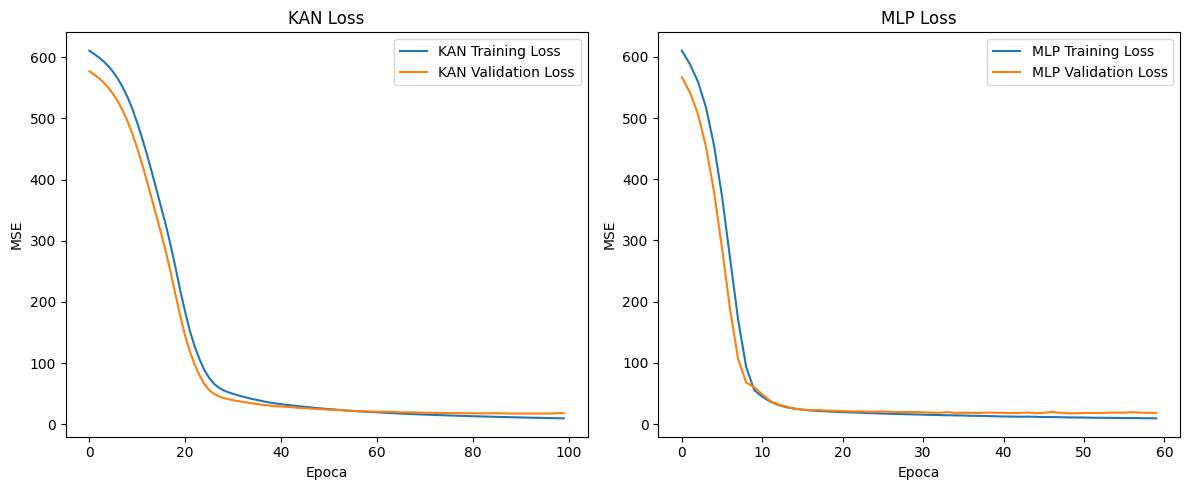

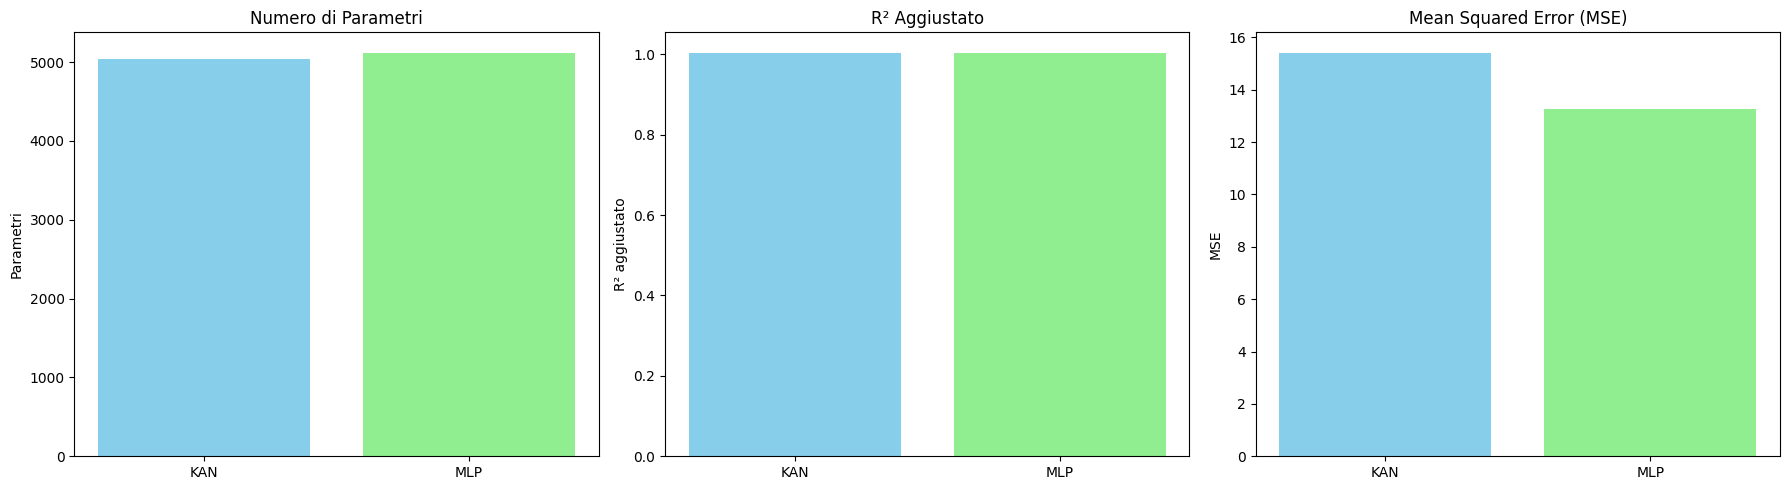

In [26]:
# Funzione per contare i parametri addestrabili del modello
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Funzione per ottenere le predizioni sul test set
def get_predictions(model, data_loader):
    model.eval()
    preds = []
    true = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            preds.append(outputs.cpu().numpy())
            true.append(y_batch.cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    true = np.concatenate(true, axis=0)
    return true, preds

# Funzione per calcolare MSE, R² e R² aggiustato
def compute_metrics(model, data_loader):
    y_true, y_pred = get_predictions(model, data_loader)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    # Per il calcolo dell'Adjusted R² si usa:
    # R2_adj = 1 - (1-R2)*(n-1)/(n-p-1)
    # Qui, 'p' può essere il numero di predittori (input_dim) oppure, per valutare la complessità del modello,
    # il numero totale di parametri addestrabili.
    # In questo esempio usiamo il numero totale di parametri.
    n = len(y_true)
    p = count_params(model)
    try:
        r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    except ZeroDivisionError:
        r2_adj = r2
    return mse, r2, r2_adj, p

# Calcola le metriche per ciascun modello sul test set
mse_kan, r2_kan, r2_adj_kan, params_kan = compute_metrics(kan_model, test_loader)
mse_mlp, r2_mlp, r2_adj_mlp, params_mlp = compute_metrics(mlp_model, test_loader)

# Tracciamento delle loss durante il training
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(kan_train_losses, label='KAN Training Loss')
plt.plot(kan_valid_losses, label='KAN Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('MSE')
plt.title('KAN Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(mlp_train_losses, label='MLP Training Loss')
plt.plot(mlp_valid_losses, label='MLP Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('MSE')
plt.title('MLP Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Creazione dei grafici per il confronto delle metriche
models = ['KAN', 'MLP']
params = [params_kan, params_mlp]
r2_adj_values = [r2_adj_kan, r2_adj_mlp]
mse_values = [mse_kan, mse_mlp]

# Creazione della figura con 3 subplot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Numero di parametri
axs[0].bar(models, params, color=['skyblue', 'lightgreen'])
axs[0].set_title('Numero di Parametri')
axs[0].set_ylabel('Parametri')

# Plot 2: R² aggiustato
axs[1].bar(models, r2_adj_values, color=['skyblue', 'lightgreen'])
axs[1].set_title('R² Aggiustato')
axs[1].set_ylabel('R² aggiustato')

# Plot 3: MSE sul test set
axs[2].bar(models, mse_values, color=['skyblue', 'lightgreen'])
axs[2].set_title('Mean Squared Error (MSE)')
axs[2].set_ylabel('MSE')

plt.tight_layout()
plt.show()